# Overview
This document aims to give an overview of the progress on the project of predicting vapour pressure using MDFPs with code and data

## Baseline
As a first step, an updated conda environment was created used to generate about a single 3D conformer for about 3000 molecules, which were  simulated in water for 5 nanoseconds. The molecules were previously curated by Dr. ShuZe Wang. All conformers are stored in the public database "conformers" and all relevant data is stored in schema cs_mdf_schema.

In [1]:
# We retrieve all conformers that were initially generated (one conformer per molecule using RDKit EmbedMolecule)

import psycopg2
import json
import pandas as pd
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)
df_mdfps = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
df_mdfps['mdfp'] = df_mdfps['mdfp'].apply(lambda x: json.loads(x['mdfp']))
print('Datapoints first experiment: ', len(df_mdfps))
df_mdfps.head()

Datapoints first experiment:  3019


,confid,molregno,mdfp,vp
0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",-0.674795
1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",-0.907920
2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",-3.000000
3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-6.822020
4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-4.772345


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2120086081380206
Fold 2: RMSE = 1.1813995099300418
Fold 3: RMSE = 1.1496915511718304
Fold 4: RMSE = 1.2512689517410922


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1285220740756896
RMSE:  1.409033519951439
MAE:  0.8752082787651263
R2:  0.8479784920717834


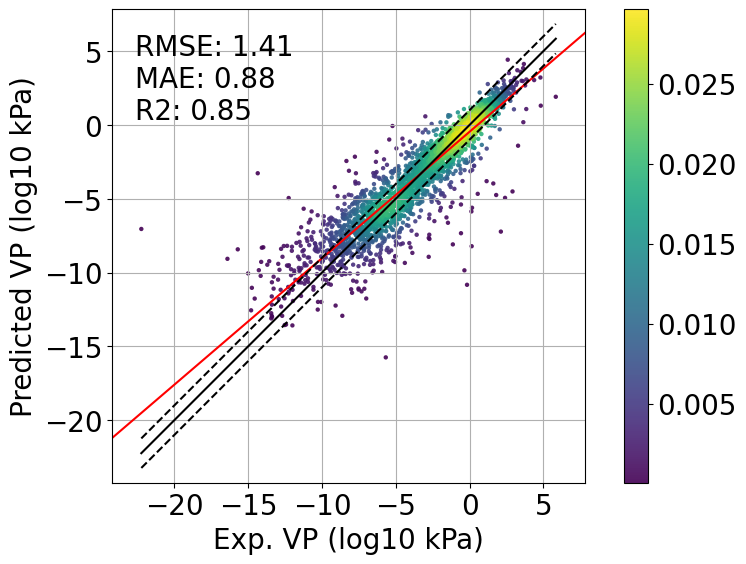

In [2]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues
from functools import reduce
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5) #we do 5-fold cross-validation
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)
slope_baseline, intercept_baseline, r2_baseline, rmse_baseline, mae_baseline = getStatValues(prediction, real)

We get decent predictions, in line with results obtained by ShuZe

## Using multiple starting conformers

We perform a few tests assing:
1. The performance of model trained on one conformer on different conformers from the same molecule
2. Does data augmentation with multiple starting conformers per mol improve the performance

### Predictive ability towards new conformers

In [3]:
#train model on one conformer of all molecules
import xgboost as xgb
import numpy as np
train_x = np.array(df_mdfps['mdfp'].tolist())
train_y = np.array(df_mdfps['vp'].tolist())
dtrain = xgb.DMatrix(train_x, label=train_y)
model_trained_oneconf_per_mol = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [20]:
#Fetch all conformers that were generated in the second round (using RDKit EmbedMultipleConfs, and picked diverse using MaxMin algorithm)
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '11093a30-b6d0-4e3f-a22b-8dcad60d6a11'
'''
# Execute the SQL query
cur.execute(sql_query)
df_new_confs = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
df_new_confs['mdfp'] = df_new_confs['mdfp'].apply(lambda x: json.loads(x['mdfp']))

RMSE:  0.8286129540353928
MAE:  0.5241263666722458
R2:  0.9476049142354924


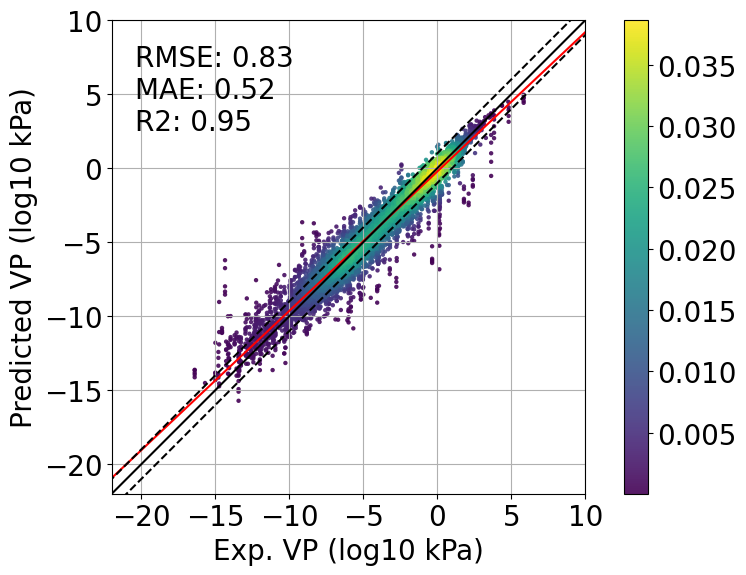

In [21]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues
test_x = np.array(df_new_confs['mdfp'].tolist())
test_y = np.array(df_new_confs['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y)
preds = model_trained_oneconf_per_mol.predict(dtest)
density_plot(test_y,preds,bounds = [-22,10])

So predicting the vapour pressure for a different starting conformer of the same molecule works quite well when looking at the correlation, but there is still quite a big RMSE.

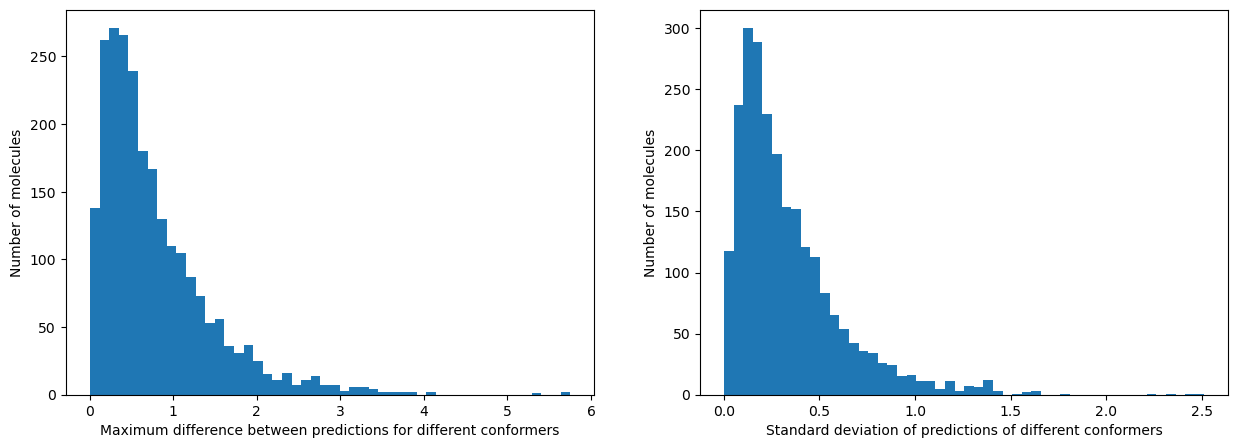

In [41]:
df_preds_new_confs = df_new_confs.copy()
df_preds_new_confs['prediction'] = preds
max_diffs = df_preds_new_confs.groupby('molregno').agg({'prediction': ['max','min']})
max_diffs['diff'] = max_diffs['prediction']['max'] - max_diffs['prediction']['min']
max_diffs_list = max_diffs['diff'].tolist()
stds = df_preds_new_confs.groupby('molregno').agg({'prediction': ['std']})
max_diffs_list = [diff for diff in max_diffs_list if diff != 0]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(max_diffs_list, bins=50)
axs[0].set_xlabel('Maximum difference between predictions for different conformers')
axs[0].set_ylabel('Number of molecules')
axs[1].hist(stds['prediction']['std'].tolist(), bins=50)
axs[1].set_xlabel('Standard deviation of predictions of different conformers')
axs[1].set_ylabel('Number of molecules')
plt.show()


### Data augmentation

In [7]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''
# Execute the SQL query
cur.execute(sql_query)
data_full = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
data_full['mdfp'] = data_full['mdfp'].apply(lambda x: json.loads(x['mdfp']))

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.3434724334011732


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1109512523742475


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.2110379137467717


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1128012466692743


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1884373175732792
RMSE:  1.364706457614459
MAE:  0.7983925809875909
R2:  0.8574307304747472


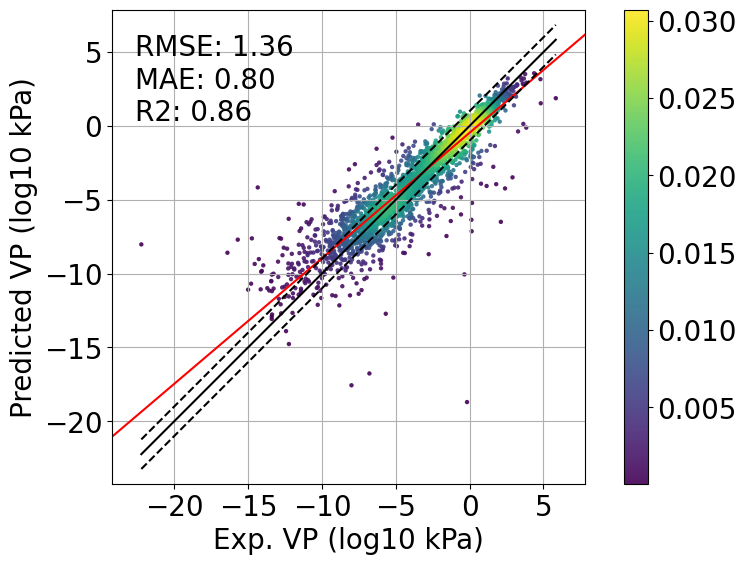

In [9]:
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
output = train_pred_xgboost(data_full,params,return_confids=True)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction)
slope_conf_augmented_averaged, intercept_conf_augmented_averaged, r2_conf_augmented_averaged, rmse_conf_augmented_averaged, mae_conf_augmented_averaged = getStatValues(prediction, real)

In [ ]:
print('r2: baseline: ', r2_baseline, " conf_augmented_averaged: ", r2_conf_augmented_averaged)
print('rmse_baseline: ', rmse_baseline, " conf_augmented_averaged: ", rmse_conf_augmented_averaged)
print('mae_baseline: ', mae_baseline, " conf_augmented_averaged: ", mae_conf_augmented_averaged)

r2: baseline:  0.8479784920717834  conf_augmented_averaged:  0.8574307304747472
rmse_baseline:  1.409033519951439  conf_augmented_averaged:  1.364706457614459
mae_baseline:  0.8752082787651263  conf_augmented_averaged:  0.7983925809875909


Data augmentation resulted in a decrease in error metrics RMSE and MAE but not much in correlation